In [1]:
# Dependency management
# --------------------------------------------------------
import sys
from pathlib import Path
project_root = Path("..").resolve()
sys.path.append(str(project_root / "scripts"))
from setup_environment import setup_paths
project_root = setup_paths()

# Data manipulation
# --------------------------------------------------------
import pandas as pd
import numpy as np
import polars as pl
import math
import time
import joblib

# Visualizations
# --------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import altair as alt
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from bokeh.plotting import figure, show
import seaborn.objects as so
import plotly.express as px

# Custom scripts
# ---------------------------------------------------------
from data_processing.cleaner import (cleaning, 
                                     compare_and_drop_duplicates)
from feature_selection.selector import (select_vars, 
                                       choose_variable_to_drop, 
                                       corr_comparison, 
                                       mutual_information)

# Correlation
# ---------------------------------------------------------
from dython.nominal import associations

# Dimension Reduction
# ---------------------------------------------------------
import umap

# Preprocessing
# ---------------------------------------------------------
from sklearn.preprocessing import (MinMaxScaler, 
                                   RobustScaler, 
                                   QuantileTransformer, 
                                   OrdinalEncoder,
                                  LabelEncoder)
from sklearn import preprocessing
from category_encoders import BinaryEncoder

# Random Forest
# ---------------------------------------------------------
from sklearn.ensemble import RandomForestClassifier

# Support Vector Machine Classifier
# ---------------------------------------------------------
from sklearn.svm import SVC

# XGBoost
# ---------------------------------------------------------
import xgboost as xgb
from xgboost import XGBClassifier

# Model selection
# ---------------------------------------------------------
from sklearn.model_selection import (train_test_split, 
                                     RepeatedStratifiedKFold, 
                                     StratifiedKFold, 
                                     cross_val_score)

# Metrics
# ---------------------------------------------------------
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             precision_score, 
                             recall_score, 
                             confusion_matrix,
                             make_scorer,
                             classification_report,
                             ConfusionMatrixDisplay
                             )

# Hyperparameter optimization
# ----------------------------------------------------------
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Other
# ---------------------------------------------------------
from collections import Counter
from tqdm import tqdm
import random
random.seed(2024)
import warnings
warnings.simplefilter("ignore", FutureWarning)

In [2]:
# Load saved merged_df.csv
merged_df = pd.read_csv(f"{project_root}/data/interim/merged_df.csv")
print(merged_df.shape)
print()
print(merged_df.columns)

(328116, 31)

Index(['#chrom', 'chromStart', 'chromEnd', 'name', 'score', 'reserved',
       'blockSizes', 'clinSign', 'reviewStatus', 'type', 'molConseq',
       'testedInGtr', 'phenotypeList', 'origin', 'cytogenetic', 'vcfDesc',
       '_clinSignCode', 'simplified_hgvs', 'Gene', 'ClinClass',
       'Classification', 'bin_class', 'classification_oncokb', 'gen',
       'gen_label', 'string_per_umap_cluster',
       'string_per_umap_cluster_description', 'string_total_clustering',
       'string_total_clustering_description', 'x_position', 'y_position'],
      dtype='object')


In [3]:
# Final columns to drop
final_drop_check = ["geneId", "_originCode", "_allTypeCode", "ClinInfo", 
                     "reserved", "numSubmit", "_variantId", "real_id", 
                     "origName", "rcvAcc", "snpId", "Start", "End", "phenotype", 
                    "_mouseOver", "Classification", "_clinSignCode", 
                    'clinSign', "ClinClass", "chromStart", "chromEnd", "gen", 
                    "vcfDesc", "testedInGtr", "string_per_umap_cluster", "string_total_clustering"]

for i in final_drop_check:
    if i in merged_df.columns:
        merged_df = merged_df.drop([i], axis=1)

merged_df.columns

Index(['#chrom', 'name', 'score', 'blockSizes', 'reviewStatus', 'type',
       'molConseq', 'phenotypeList', 'origin', 'cytogenetic',
       'simplified_hgvs', 'Gene', 'bin_class', 'classification_oncokb',
       'gen_label', 'string_per_umap_cluster_description',
       'string_total_clustering_description', 'x_position', 'y_position'],
      dtype='object')

<hr style="height:10px; border-width:0">


# XGBoost
- Less columns generated from preprocessing

In [15]:
y = merged_df["bin_class"].copy()

prep_data = pd.DataFrame()
num_cols = merged_df.select_dtypes(include=['float']).columns

for i in num_cols:
    prep_data[i] = preprocessing.scale(merged_df[i])

cat_data = pd.DataFrame()
cat_data = merged_df.select_dtypes(include=['object', "int"]).copy()
cat_data = cat_data.drop(["bin_class"], axis=1)

for column in cat_data.columns:
    cat_data[column] = cat_data[column].astype("category")

# XGBoost not encoded categorical columns
X = pd.concat([cat_data, prep_data], axis=1)

100%|█████████████████████████████████████████████████████████| 50/50 [2:25:31<00:00, 174.62s/trial, best loss: -0.8762782256861277]                                                       

Best parameters found:  {'colsample_bytree': 0.7031223382097587, 'gamma': 0.411053792537182, 'learning_rate': 0.10239257379760176, 'max_depth': 6, 'n_estimators': 150, 'reg_alpha': 0.0958846872973458, 'reg_lambda': 0.2454703755042342, 'subsample': 0.8286650554322186}

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     87713
           1       0.87      0.89      0.88     10722

    accuracy                           0.97     98435
   macro avg       0.93      0.94      0.93     98435
weighted avg       0.97      0.97      0.97     98435



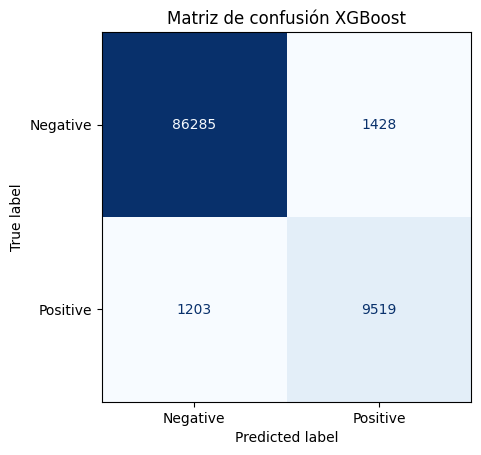

Metricas para XGBoost con Hyperopt:
Accuracy :  0.9733
Precision:  0.8696
Recall   :  0.8878
F1 Score :  0.8786


In [23]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Hyperparameter search space
search_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 50),  # Narrow the range and step size
    'max_depth': hp.quniform('max_depth', 3, 6, 1),  # Shallower trees
    'learning_rate': hp.loguniform('learning_rate', -2.5, -0.693),  # Equivalent to 0.08 to 0.5
    'subsample': hp.uniform('subsample', 0.7, 1.0),  # Narrow the range
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),  # Narrow the range
    'gamma': hp.uniform('gamma', 0, 5),  # Limit the upper bound
    'reg_alpha': hp.loguniform('reg_alpha', -3, 1.5),  # Equivalent to 1e-3 to 4.5
    'reg_lambda': hp.loguniform('reg_lambda', -3, 1.5),  # Equivalent to 1e-3 to 4.5
}


# Store trials results
trials = Trials()

# Define la función objetivo
def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])

    model = xgb.XGBClassifier(
        objective='binary:logistic',
        enable_categorical=True,
        eval_metric='auc',
        **params
    )

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1 = cross_val_score(model, X_train, y_train, cv=skf, scoring=make_scorer(f1_score)).mean()

    return {'loss': -f1, 'status': STATUS_OK}

# Optimization with 50 evaluations
best = fmin(fn=objective,
            space=search_space,
            algo=tpe.suggest,
            max_evals=50,  
            trials=trials)

# Results stored in trials
results_df = pd.DataFrame(trials.results)
params_df = pd.DataFrame([trial['misc']['vals'] for trial in trials.trials])
summary_df = pd.concat([params_df, results_df['loss']], axis=1)
summary_df.to_csv(f"{project_root}/models/train_models/xgb_metrics.csv")

best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])

print()
print("="*80)
print("Best parameters found: ", best)
print("="*80)
print()

# Train final model with best hyperparameters
final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    enable_categorical=True,
    eval_metric='auc',
    early_stopping_rounds=10,  
    **best
)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Predict using test dataset
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))

# XGboost metrics
accuracy_xgb = accuracy_score(y_test, y_pred)
precision_xgb = precision_score(y_test, y_pred)
recall_xgb = recall_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred)
conf_matrix_xgb = confusion_matrix(y_test, y_pred)

# Confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix_xgb, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues, values_format='.0f', colorbar=False)  # Cambiar formato a flotantes
plt.title('Matriz de confusión XGBoost')
plt.show()

# Metrics
print("Metricas para XGBoost con Hyperopt:")
print("Accuracy : ", round(accuracy_xgb,4))
print("Precision: ", round(precision_xgb,4))
print("Recall   : ", round(recall_xgb,4))
print("F1 Score : ", round(f1_xgb,4))

In [ ]:
# Export trained model
xgb_filename = f'{project_root}/models/trained_models/xgb_m1_opt.sav'
joblib.dump(final_model, xgb_filename)

<hr style="height:10px; border-width:0">

# Random Forest

- Preprocessing produces more columns. Long optimization times

In [4]:
y = merged_df["bin_class"].copy()

prep_data = pd.DataFrame()
num_cols = merged_df.select_dtypes(include=['float']).columns

for i in num_cols:
    prep_data[i] = preprocessing.scale(merged_df[i])

cat_data = pd.DataFrame()
cat_data = merged_df.select_dtypes(include=['object', "int"]).copy()
cat_data = cat_data.drop(["bin_class"], axis=1)

label_encoded_df = pd.DataFrame()
binary_encoded_df = pd.DataFrame()

# Encoders
label_encoder = LabelEncoder()
binary_encoder = BinaryEncoder()

for column in cat_data.columns:
    
    unique_values = cat_data[column].nunique()
    cat_data[column] = cat_data[column].astype("category")
    
    if unique_values == 2:
        label_encoded_df[column] = label_encoder.fit_transform(cat_data[column])
        
    elif unique_values > 2:

        encoded = binary_encoder.fit_transform(cat_data[column])
        encoded.columns = [f'{column}_{col}' for col in encoded.columns]  # Rename columns with original prefix
        binary_encoded_df = pd.concat([binary_encoded_df, encoded], axis=1)

# Final encoded dataframe
X = pd.concat([label_encoded_df, binary_encoded_df, prep_data], axis=1)

100%|█████████████████████████████████████████████████████████| 50/50 [1:53:48<00:00, 136.57s/trial, best loss: -0.8620866000997067]

Best parameters found:  {'bootstrap': 1, 'max_depth': 14, 'min_samples_leaf': 1, 'n_estimators': 110}

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     87713
           1       0.85      0.88      0.87     10722

    accuracy                           0.97     98435
   macro avg       0.92      0.93      0.92     98435
weighted avg       0.97      0.97      0.97     98435



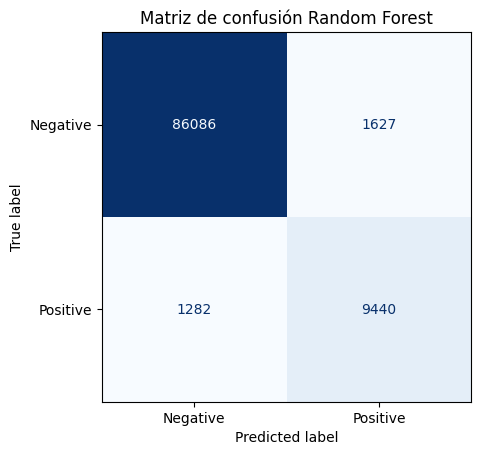

Metricas para Random Forest con Hyperopt:
Accuracy :  0.9704
Precision:  0.853
Recall   :  0.8804
F1 Score :  0.8665


In [9]:
# Split the dataset into training (70%) and validation (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Define the search space for hyperparameters
search_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),  # Reduced range for quicker evaluation
    'max_depth': hp.quniform('max_depth', 3, 15, 1),  # Shallower trees
    #'min_samples_split': hp.quniform('min_samples_split', 2, 10, 2),  # Reduce upper bound
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1),  # Reduce upper bound
    #'max_features': hp.uniform('max_features', 0.5, 1.0),  # Focus on a narrower range for more features
    'bootstrap': hp.choice('bootstrap', [True, False])  # No change
}

# Initialize a Trials object to store intermediate results
trials = Trials()

# Define the objective function
def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    #params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])

    model = RandomForestClassifier(
        random_state=42,
        **params
    )

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1 = cross_val_score(model, X_train, y_train, cv=skf, scoring=make_scorer(f1_score)).mean()
    
    return {'loss': -f1, 'status': STATUS_OK}

# Run the optimization
best = fmin(fn=objective, 
            space=search_space, 
            algo=tpe.suggest, 
            max_evals=50,  # Adjust the number of evaluations
            trials=trials)

# Results stored in trials
results_df = pd.DataFrame(trials.results)
params_df = pd.DataFrame([trial['misc']['vals'] for trial in trials.trials])
summary_df = pd.concat([params_df, results_df['loss']], axis=1)
summary_df.to_csv(f"{project_root}/models/train_models/rf_metrics.csv")

# Convert integer types where necessary
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
#best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])

print()
print("="*80)
print("Best parameters found: ", best)
print("="*80)
print()

# Train the final model on the full training data with the best parameters
final_model = RandomForestClassifier(
    random_state=42,
    **best
)

final_model.fit(X_train, y_train)

# Predictions with final model
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Metrics
accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred)
recall_rf = recall_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred)
conf_matrix_rf = confusion_matrix(y_test, y_pred)

# Confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix_rf, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues, values_format='.0f', colorbar=False)  # Cambiar formato a flotantes
plt.title('Matriz de confusión Random Forest')
plt.show()

# Printing metrics
print("Metricas para Random Forest con Hyperopt:")
print("Accuracy : ", round(accuracy_rf,4))
print("Precision: ", round(precision_rf,4))
print("Recall   : ", round(recall_rf,4))
print("F1 Score : ", round(f1_rf,4))

In [ ]:
rf_filename = f'{project_root}/models/trained_models/rf_m1_opt.sav'
joblib.dump(final_model, rf_filename)

<hr style="height:10px; border-width:0">

# Support Vector Machine Classifier

- Shape of X (328116, 103) too big for training.
  Options to keep all samples:
  - Dimension reduction
  - Encoding preprocessing scheme (Did not work)

In [5]:
y = merged_df["bin_class"].copy()

prep_data = pd.DataFrame()
num_cols = merged_df.select_dtypes(include=['float']).columns

for i in num_cols:
    prep_data[i] = preprocessing.scale(merged_df[i])

cat_data = pd.DataFrame()
cat_data = merged_df.select_dtypes(include=['object', "int"]).copy()
cat_data = cat_data.drop(["bin_class"], axis=1)

label_encoded_df = pd.DataFrame()
binary_encoded_df = pd.DataFrame()

# Encoders
label_encoder = LabelEncoder()
binary_encoder = BinaryEncoder()

for column in cat_data.columns:
    
    unique_values = cat_data[column].nunique()
    cat_data[column] = cat_data[column].astype("category")
    
    if unique_values == 2:

        label_encoded_df[column] = label_encoder.fit_transform(cat_data[column])
        
    elif unique_values > 2:

        encoded = binary_encoder.fit_transform(cat_data[column])
        encoded.columns = [f'{column}_{col}' for col in encoded.columns]  
        binary_encoded_df = pd.concat([binary_encoded_df, encoded], axis=1)

# Final encoded dataframe
X = pd.concat([label_encoded_df, binary_encoded_df, prep_data], axis=1)

## Another preprocessing scheme

In [29]:
X = merged_df.drop(["bin_class"],axis=1)
y = merged_df["bin_class"].values.copy()

categorical_features = X.select_dtypes(["object", "int"]).columns.tolist()
numerical_features = X.select_dtypes(["float"]).columns.tolist()
n_unique_categories = X[categorical_features].nunique().sort_values(ascending=False)
high_cardinality_features = n_unique_categories[n_unique_categories > 10].index
low_cardinality_features = n_unique_categories[n_unique_categories <= 10].index

phenotypeList                          22740
name                                    2059
simplified_hgvs                         1935
Gene                                     136
cytogenetic                              123
blockSizes                                49
#chrom                                    23
gen_label                                 20
molConseq                                 19
origin                                    19
string_per_umap_cluster_description       17
string_total_clustering_description       10
type                                       8
classification_oncokb                      6
score                                      4
reviewStatus                               4
dtype: int64

In [ ]:
high_cardinality_features = n_unique_categories[n_unique_categories > 10].index
low_cardinality_features = n_unique_categories[n_unique_categories <= 10].index

# Split the dataset into training (70%) and validation (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
print("X_train: ", X_train.shape)

# Define your column preprocessor
mixed_encoded_preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", numerical_features),
        (
            "high_cardinality",
            TargetEncoder(),#target_type="continuous"),
            high_cardinality_features,
        ),
        (
            "low_cardinality",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            low_cardinality_features,
        ),
    ],
    verbose_feature_names_out=False,
)
mixed_pipe = make_pipeline(mixed_encoded_preprocessor)

# Define the search space for SVM hyperparameters
search_space = {
    'svc__C': hp.loguniform('svc__C', -3, 2),  # C ranges from 0.001 to 100
    'svc__gamma': hp.loguniform('svc__gamma', -4, 0),  # gamma ranges from 0.0001 to 1 for RBF
    #'svc__kernel': hp.choice('svc__kernel', ['linear', 'rbf']),  # Choose between linear and RBF kernels
}

# Initialize a Trials object to store intermediate results
trials = Trials()

# Define the objective function
def objective(params):
    # Define the SVM pipeline with preprocessing
    model = Pipeline([
        ('preprocessor', mixed_pipe),
        ('svc', SVC(random_state=42))
    ])

    # Update the SVM parameters
    model.set_params(**params)

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1 = cross_val_score(model, X_train, y_train, cv=skf, scoring=make_scorer(f1_score)).mean()
    
    return {'loss': -f1, 'status': STATUS_OK}

# Run the optimization
best = fmin(fn=objective, 
            space=search_space, 
            algo=tpe.suggest, 
            max_evals=50,  # Adjust the number of evaluations
            trials=trials)

# Train the final SVM model with the best parameters on the full training data
final_model = Pipeline([
    ('preprocessor', mixed_encoded_preprocessor),
    ('svc', SVC(random_state=42, C=best['svc__C'], gamma=best['svc__gamma'], kernel=best['svc__kernel']))
])

final_model.fit(X_train, y_train)

# Validate the model on the test set
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Metrics for SVM
accuracy_svm = accuracy_score(y_test, y_pred)
precision_svm = precision_score(y_test, y_pred)
recall_svm = recall_score(y_test, y_pred)
f1_svm = f1_score(y_test, y_pred)
conf_matrix_svm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix_svm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues, values_format='.0f', colorbar=False)  # Change format to float
plt.title('Confusion Matrix for SVM with Preprocessing')
plt.show()

# Print metrics
print("Metrics for SVM with Hyperopt and Preprocessing:")
print("Accuracy : ", round(accuracy_svm,4))
print("Precision: ", round(precision_svm,4))
print("Recall   : ", round(recall_svm,4))
print("F1 Score : ", round(f1_svm,4))

X_train:  (229681, 18)
  0%|                                                                                                                                               | 0/50 [00:00<?, ?trial/s, best loss=?]

# GNNs

# KANNs

# LNNs